In [12]:
# training GANS is a slow process: be sure to switch to hardware accelerator GPU in 'change runtime type', and switch to high-RAM when prompted.
# GAN procedure mostly taken from https://github.com/yandexdataschool/mlhep2018/

# Download dataset
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz # 233 MB!
!tar -xf lfw-funneled.tgz

--2024-03-17 17:12:44--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2024-03-17 17:12:44--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

lfw_attributes.txt  100%[===================>]  14.19M  47.5MB/s    in 0.3s    

2024-03-17 17:12:45 (47.5 MB/s) - ‘lfw_attributes.txt’ saved [14879205/14879205]

--2024-03-17 17:12:45--  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
Resolving vis-www.cs.umass.edu (vi

In [13]:
# Some data-handling tools and imports

import numpy as np
import os
import subprocess
from imageio import imread
#from scipy.misc import imresize
#!pip install pillow
from PIL import Image
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45):

    # read attrs
    # the header row begins with a #, which we want to ignore
    with open(attrs_name) as attributes_file:
        attributes_file.readline()
        ugly_header = attributes_file.read(2)
        assert ugly_header == "#\t"
        df_attrs = pd.read_csv(attributes_file, sep='\t', skipinitialspace=True)
        #print(df_attrs)
        #print(df_attrs.columns.values.tolist())

    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    initial_depth = dirname.count(os.sep)
    for dirpath, dirnames, filenames in os.walk(dirname):
        if dirpath.count(os.sep) - initial_depth > 1:
            continue
        for fname in filenames:
            if fname.endswith(".jpg"):
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                fpath = os.path.join(dirpath, fname)
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    # mass-merge
    # (photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: Image.fromarray(img).resize([dimx,dimy]) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"], axis=1)

    return all_photos, all_attrs

In [14]:
# Fetch the datasets of faces

#%env CUDA_VISIBLE_DEVICES=0

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

# a utility to load the dataset
data, _ = fetch_lfw_dataset(dimx=36, dimy=36, images_name="lfw_funneled", attrs_name="lfw_attributes.txt",)

# preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

<ipython-input-15-5c4175b73194>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,5,1)


dbg: [0.7176471  0.5411765  0.43529412]


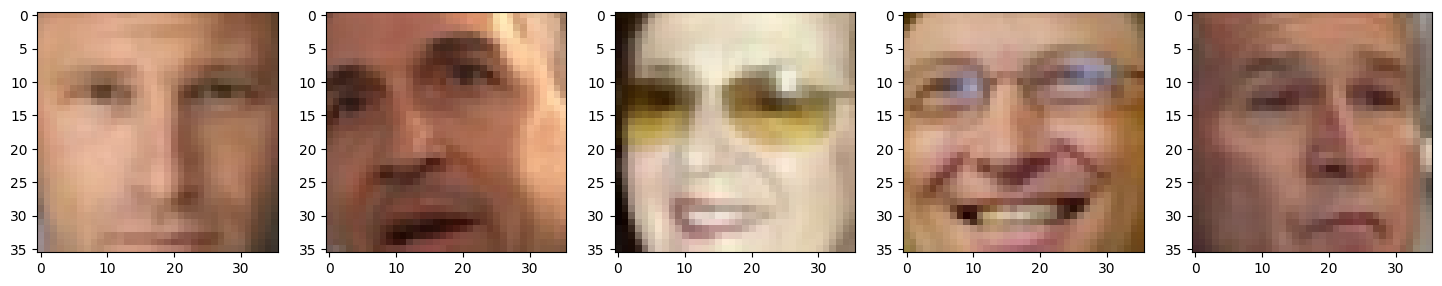

In [15]:
# show some random (real) faces from our dataset

plt.figure(figsize=[18, 18])
plt.axis('off');

plt.subplot(1,5,1)
plt.imshow(data[0], cmap="gray", interpolation="none")
for i in range(4):
  plt.subplot(1,5,i+2)
  plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")


# here I just wante dto figure out how the RGB values of pixels work
print("dbg:", data[0][0][0])



In [16]:
import tensorflow as tf

# Please don't run tensorfow without this config. Without it you'll take the whole memory of the GPU
# and make it unusable by anyone else
#gpu_options = tf.GPUOptions(allow_growth=True)
#sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
# Edit: for colab, resources are limited on the server-side. Go hog.
sess = tf.compat.v1.InteractiveSession()

tf.compat.v1.disable_eager_execution()
#tf.compat.v1.disable_v2_behavior()


import keras
from keras.models import Sequential
from keras import layers as L
from functools import partial

In [17]:
# If we can't tell good faces from bad, we delegate it to yet another neural network!
# That makes two of them:
# Generator - takes random noise for inspiration and tries to generate a face sample.
# Let's call him G(z), where z is a gaussian noize.
# Discriminator - takes a face sample and tries to tell if it's real or fake.
# Predicts the probability of input image being a real face
# Let's call him D(x), x being an image.
# D(x) is a prediction for real image and D(G(z)) is prediction for the face made by generator.

# Now it's your choise which GAN to build: Jensen-Shannon, or Wasserstein
# In addition to the theoretical difference, a couple of practical matters:
#  Jensen-Shannon GAN should learn several times faster, but is more sensitive to mode collapse and vanishing gradients.
#  Wasserstein GAN doesn't go well in company of batch normalization and ELU activation.

GAN_TYPE = "Jensen-Shannon"
#GAN_TYPE = "Wasserstein"


In [21]:
# Make the Generator.
#  It takes a random sample as input (size CODE_SIZE) and generates a face with FIGURE_SIZE output size.
#  To enlarge from CODE_SIZE to FIGURE_SIZE (#pix_x by #pix_y by #rgb) you need to use
#  some Deconvolution2D and UpSampling2D layers.

CODE_SIZE = 256

# Activations experimentally selected. Will most likely work
# for other combinations of activations/architectures
if GAN_TYPE == "Wasserstein":
    generator_activation = partial(keras.activations.relu, alpha=0)
elif GAN_TYPE == "Jensen-Shannon":
    generator_activation = keras.activations.elu

with tf.name_scope("Generator"):
    # A few Deconv layers. Feel free to add more, but that will make learning even slower
    generator = Sequential(name="Generator")
    generator.add(L.InputLayer([CODE_SIZE],name='noise'))
    generator.add(L.Dense(10*8*8, activation=generator_activation))
    ### STUDENT CODE HERE ###
    ### --> Write the network for the Generator.
    ###  It takes a random sample as input (size CODE_SIZE) and generates a face with FIGURE_SIZE output size.
    ###  To enlarge from CODE_SIZE to FIGURE_SIZE (#pix_x by #pix_y by #rgb) you need to use
    ###  some Conv2DTranspose and UpSampling2D layers.
    ###  Make sure to use the 'generator_activation' as activation.
    ###  A typical network size has ~300,000 free parameters.

    # I used this stackoverflow post to understand how the output shape depends on the
    # deconvolution layers:
    # https://stackoverflow.com/questions/35980044/getting-the-output-shape-of-deconvolution-layer-using-tf-nn-conv2d-transpose-in
    # furthermore this paper helped me understand how the particular choices of parameters inside the
    # deconvolution layers affect the final output:
    # https://core.ac.uk/download/pdf/225893235.pdf

    # reshaping the data into the form 8 x 8 x 10 as defined in the densly connected layer above
    generator.add(L.Reshape((8,8,10)))

    # starting the deconvolution (transpose convolution) stack:
    # the idea is to first use lower number of filters and increase it over the layers -
    # this is done to capture the low-level feautures in the initial layers and then gradually
    # increase the complexity. The inverse is applied to the kernel size but follows the same logic -
    # at first the higher kernel size caputres global features and then decreaseses over the layers
    # to capture local features. kernel_size could as well be written in the form (n,n), but the
    # syntax assumes a square matrix so a single value was used. Strides is the number of pixels
    # the kernel moves with each step.

    generator.add(L.Conv2DTranspose(filters=32, kernel_size=5, strides = 1, activation=generator_activation))

    # Batch normalization is applied between the deconvolution layers to ensure that the activations
    # (gradients) between the steps don't blow up (which could lead to overfitting) or vanish
    # (which would slow down the learning process).

    generator.add(L.BatchNormalization())

    generator.add(L.Conv2DTranspose(filters=32, kernel_size=4, strides = 1, activation=generator_activation))

    # upsampling layer is added to recover the lost information (spatial resolution) during the
    # deconvolution layers

    generator.add(L.UpSampling2D(size=2))

    generator.add(L.Conv2DTranspose(filters=64, kernel_size=3, strides = 1, activation=generator_activation))
    generator.add(L.BatchNormalization())

    generator.add(L.Conv2DTranspose(filters=64, kernel_size=3, strides = 1, activation=generator_activation))
    generator.add(L.BatchNormalization())

    generator.add(L.Conv2DTranspose(filters=64, kernel_size=3, strides = 1, activation=generator_activation))
    generator.add(L.BatchNormalization())

    generator.add(L.Conv2DTranspose(filters=64, kernel_size=3, strides = 1, activation=generator_activation))
    generator.add(L.BatchNormalization())


    # five deconvolution layers were chosen as too little could lead to not capturing enough detalis
    # while too much could lead to overfitting and would be computationally inefficient. After playing around with
    # the values of parameters inside the deconvolution layers and the umsapling layer the desired number
    # of ~300000 trainable parameters was achieved (it is 298627 to be exact)

    # I also found one post online that recommended to use a stride of two instead of using
    # upsampling between the layers of deconvolutions but it had no effect on my final results
    # (I mean it still produced random images).

    # I have tried many versions of the generator. This is my original one, developed
    # by trying to understand the theory behind the deconvolutions, but another one I tried is the code
    # found on GitHub: https://github.com/alex-rbch/GAN_LFW/blob/main/GAN_model.ipynb
    # This generator model looked as follows:
            #    generator = tf.keras.Sequential([
            #     Dense(640, input_shape=(CODE_SIZE,), activation='relu'),
            #     BatchNormalization(),
            #     Reshape((8, 8, 10)),
            #     Conv2DTranspose(filters=64, kernel_size=(5, 5), activation='elu'),
            #     Conv2DTranspose(filters=64, kernel_size=(5, 5), activation='elu'),
            #     BatchNormalization(),
            #     UpSampling2D(size=(2, 2)),
            #     Conv2DTranspose(filters=32, kernel_size=3, activation='elu'),
            #     Conv2DTranspose(filters=32, kernel_size=3, activation='elu'),
            #     Conv2DTranspose(filters=32, kernel_size=3, activation='elu'),
            #     BatchNormalization(),
            #     Conv2D(filters=3, kernel_size=3, activation=None)
            # ], name="my_generator")
    # The author claims to succeed in creating GAN images, however with this same code I couldn't.
    # This leads me to believe that there is something more underyling here that prevented me from succeeding.
    # I have tried many versions of code and some I have run for more than 30k epochs, but all of them failed.


    # the docummentation provided with the tutorial file mentioned that it's best to use
    # tanh as the activation function for the last layer
    generator.add(L.Conv2D(3,kernel_size=3,activation="tanh"))



    assert generator.output_shape[1:] == IMG_SHAPE, \
    "generator must output an image of shape %s, but instead it produces %s" % \
        (IMG_SHAPE, generator.output_shape[1:])

    generator.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 640)               164480    
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 10)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 12, 12, 32)        8032      
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 12, 12, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 15, 15, 32)        16416     
 Transpose)                                                      
                                                         

In [22]:
# Make the Discriminator.

# It is your usual convolutional network with interlooping convolution and pooling layers:
#  It takes a figure as input, and a simple output to separate "Yes" (figure is real) and "No" (figure is fake)
# The network does not include dropout/batchnorm to avoid learning complications.
# We also regularize the pre-output layer to prevent discriminator from being too certain.

discriminator_activation = partial(keras.activations.relu, alpha=0.3)

with tf.name_scope("Discriminator"):
    discriminator = Sequential(name="Discriminator")
    discriminator.add(L.InputLayer(IMG_SHAPE))

    ### STUDENT CODE HERE ###
    ### Build the network for the Discriminator.
    ### Typically described as 'Roughly the inverse of the generator'.
    ### As the discriminator needs to learn complex features, a series of multiple Conv2D
    ###  layers is recommended, alternated with some MaxPool2D layers to filter out the relevant kernels.
    ### A final Flatten and Dense layer is recommended to learn the interesting combinations of kernels.
    ### Be sure to use the discriminator_activation as activation for each layer.
    ### A typical network has a size of ~400,000 free parameters.

    # For the discriminator I wanted to use the same approach as for the generator,
    # mainly increasing the filter size with each convolution layer
    # but when looking over projects of different people and the paper I have cited
    # in the generator part I noticed that almost all of them use a constant filter number
    # in the discriminator. I have however noticed that a lot of projects used a decreasing
    # kernel size (which to my understanding makes the model first recognize global and then local
    # features) so I also used that approach.

    discriminator.add(L.Conv2D(32,kernel_size=3,activation=discriminator_activation))
    discriminator.add(L.Conv2D(32,kernel_size=3,activation=discriminator_activation))

    # Pooling downsamples the feature map by a factor of two. It allows
    # the model to learn more general features and reduces the computational complexity

    discriminator.add(L.MaxPool2D(pool_size=2))

    discriminator.add(L.Conv2D(32,kernel_size=2,activation=discriminator_activation))
    discriminator.add(L.Conv2D(32,kernel_size=2,activation=discriminator_activation))


    discriminator.add(L.MaxPool2D(pool_size=2))
    # spatial dropout randomly drops entire feature maps in order for the model to not
    # focus on very specific features which could lead to overfitting
    discriminator.add(L.SpatialDropout2D(0.3))

    # flattening the data into a 1D array, which is needed before feeding it into the
    # dense layer
    discriminator.add(L.Flatten())

    discriminator.add(L.Dense(256, activation=discriminator_activation))

    # same as with the generator, I have tested multiple models for the discriminator, unfortunately
    # to no avail. At the end of the documment I have attached my additional comments about the process.

    ### END STUDENT CODE ###

    if GAN_TYPE == "Wasserstein":
        # Wasserstein discriminator values are unconstrained
        discriminator.add(L.Dense(1))
    elif GAN_TYPE == "Jensen-Shannon":
        # Jensen-Shannon expects probabilities
        discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

    discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 34, 34, 32)        896       
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 32)        4128      
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                

In [23]:
# Helper function to create a shuffling image stream for training

def get_tf_dataset(dataset, batch_size):
    """
    Produces an infinite stram of Tensorflow batches from a numpy dataset. The dataset is shuffled every epoch.
    Args:
       dataset: np.array[n_examples, ...]
       batch_size: int, batch size of the results
    Reuturns:
       Tensor, containing the next batch
    """
    if isinstance(dataset, tf.Tensor):
        N_EXAMPLES = dataset.shape[0]
    else:
        N_EXAMPLES = dataset[0].shape[0]
    shuffler = tf.data.experimental.shuffle_and_repeat(N_EXAMPLES)
    dataset_tf = tf.data.Dataset.from_tensor_slices(dataset)
    suffled_ds = shuffler(dataset_tf)
    #return suffled_ds.batch(batch_size).prefetch(1).make_one_shot_iterator().get_next()
    return tf.compat.v1.data.make_one_shot_iterator( suffled_ds.batch(batch_size) ).get_next()


In [24]:
# Initialize training data setup.

# Notes on strategy: we will train the two networks concurrently:
#  - Train discriminator to better distinguish real data from current generator
#  - Train generator to make discriminator think generator is real
# Since discriminator is a differentiable neural network, we train both with gradient descent.
# Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).
# Tricks:
# Train generator with adam to speed up training. Discriminator trains with SGD to avoid problems with momentum.
# More: https://github.com/soumith/ganhacks

# Obtain the training data faces stream for the discriminator
train_batch_size = 100
real_data = get_tf_dataset(data, train_batch_size)

# Generate the noise data to be used in the generator training
noise_batch_size = tf.compat.v1.placeholder(tf.int32, shape=[], name="noise_batch_size")
noise = tf.random.normal([noise_batch_size, CODE_SIZE], dtype=tf.float32, name="noise")

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [25]:
with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

  # Run data and noise through the networks
  discriminator_real = discriminator(real_data)
  generated_data = generator(noise)
  discriminator_generated = discriminator(generated_data)

  # Configure custom learning and loss details, specific to the GAN strategy type

  if GAN_TYPE == "Wasserstein":
    with tf.name_scope("gradient_loss"):
        alpha = tf.random_uniform(shape=[tf.shape(generated_data)[0], 1, 1, 1], minval=0., maxval=1.)
        interpolates = alpha*real_data + ((1.-alpha)*generated_data)
        disc_interpolates = discriminator(interpolates)
        gradients = tf.gradients(disc_interpolates, [interpolates])[0]
        slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
        gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.))
    EMD_loss = tf.reduce_mean(discriminator_generated) - tf.reduce_mean(discriminator_real)
    LAMBDA = 10.
    discriminator_loss = EMD_loss + LAMBDA*gradient_penalty
    generator_loss = -tf.reduce_mean(discriminator_generated)

  if GAN_TYPE == "Jensen-Shannon":
    logp_real = discriminator(real_data)
    logp_gen = discriminator(generated_data)
    discriminator_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])
    generator_loss = -tf.reduce_mean(logp_gen[:,1])

# Get gradients
disc_grads = disc_tape.gradient(discriminator_loss, discriminator.trainable_weights)
gen_grads  = gen_tape.gradient(generator_loss, generator.trainable_weights)

# Define the optimizer for both networks.
# The values below are rough suggestions aimed at not exploding a discriminator
# of complexity roughly equal to the complexity of the generator.
disc_learning_rate = 1e-3

if GAN_TYPE == "Wasserstein":
    # https://arxiv.org/pdf/1704.00028.pdf
    #disc_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta1=0, beta2=0.9).minimize(
    #      discriminator_loss, var_list=discriminator.trainable_weights)
    disc_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta1=0, beta2=0.9).apply_gradients(
        zip(disc_grads, discriminator.trainable_weights))
elif GAN_TYPE == "Jensen-Shannon":
    #disc_optimizer = tf.keras.optimizers.SGD(disc_learning_rate).minimize(
    #    discriminator_loss, var_list=discriminator.trainable_weights)
    disc_optimizer = tf.keras.optimizers.SGD(disc_learning_rate).apply_gradients(
        zip(disc_grads, discriminator.trainable_weights))


if GAN_TYPE == "Wasserstein":
    # https://arxiv.org/pdf/1704.00028.pdf
    #gen_optimizer = tf.keras.optimizers.Adam(1e-4, beta1=0, beta2=0.9).minimize(
    #    generator_loss, var_list=generator.trainable_weights)
    gen_optimizer = tf.keras.optimizers.Adam(1e-4, beta1=0, beta2=0.9).apply_gradients(
        zip(gen_grads, generator.trainable_weights))
elif GAN_TYPE == "Jensen-Shannon":
    #gen_optimizer = tf.keras.optimizers.Adam(1e-4).minimize(generator_loss, var_list=generator.trainable_weights)
    gen_optimizer = tf.keras.optimizers.Adam(1e-4).apply_gradients(
        zip(gen_grads, generator.trainable_weights))

learning_summary = tf.compat.v1.summary.merge([
    tf.compat.v1.summary.scalar("discriminator_loss", discriminator_loss),
    tf.compat.v1.summary.scalar("generator_loss", generator_loss)
])

images_summary = tf.compat.v1.summary.image("generated_images", generator(noise))


In [26]:
# initialize all variables.
sess.run(tf.compat.v1.global_variables_initializer())

In [27]:
# Define helper functions to evaluate the Gen. and Disc. over some data batches

def sample_noise_batch(bsize):
    # Get a new batch of noise samples
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    # Get a batch of real faces
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    # Let the generator create some faces from noise and show them
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images) != 0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE), cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE), cmap="gray")
        plt.axis('off')

def sample_probas(bsize):
    # Let the discriminator predict 'True' or 'False' label for some real and some generated faces.
    #  (note that this is actually a continuous number - a sort of 'probability')
    fig, ax = plt.subplots()
    ax.set_title('Generated vs real data')
    ax.hist(discriminator.predict(sample_data_batch(bsize)).ravel(),
             label='D(x)', alpha=0.5, density=True)
    ax.hist(discriminator.predict(generator.predict(sample_noise_batch(bsize))).ravel(),
             label='D(G(z))', alpha=0.5,  density=True)
    ax.legend(loc='best')
    return fig, ax

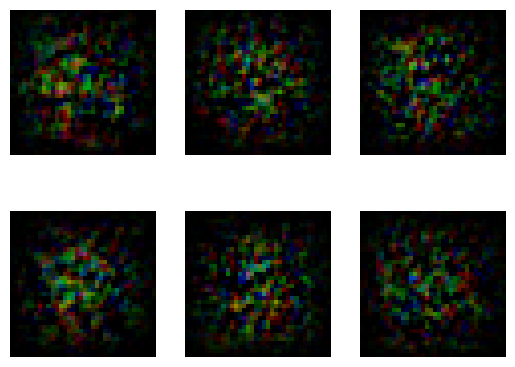

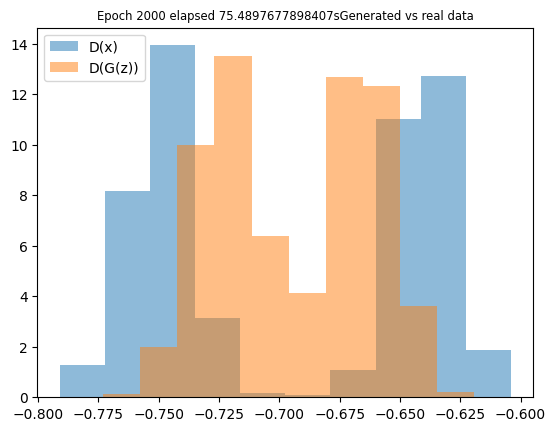

KeyboardInterrupt: 

In [28]:
# Actual training

from IPython import display
import os

import time

LOGDIR = "./"
MODEL_NAME = "faces_GAN_%s_noreg_v1" % GAN_TYPE
MODEL_DIR = "./"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_WEIGHTS_FILE =  os.path.join(MODEL_DIR, ("%s.ckpt" % MODEL_NAME))
VALIDATION_INTERVAL = 50 # time between intermediate visual updates.
TOTAL_ITERATIONS = int(5e4) # was 5e4 but colab takes too long
# Number of discriminator training iterations per generator iteration
# In our tests for discriminator of roughly as complexity as discriminator
# 5 worked for both Wasserstein and Jensen–Shannon.
DISCRIMINATOR_ITERATIONS = 5

# Save the intermediate weights, such that if our training gets interrupted,
#  We don't have to restart from scratch.
train_writer = tf.compat.v1.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
train_writer.add_graph(tf.compat.v1.get_default_graph())
weights_saver = tf.compat.v1.train.Saver()

if(os.path.exists(MODEL_WEIGHTS_FILE)) :
  try:
    weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
  except (tf.errors.NotFoundError, tf.errors.InvalidArgumentError):
    print("Can't restore parameters: no file with weights")

start_time = time.time()

for epoch in range(TOTAL_ITERATIONS):


    for i in range(DISCRIMINATOR_ITERATIONS):
        # Train the discriminator
        sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
    # Train the generator
    summary, _ = sess.run([learning_summary, gen_optimizer], {noise_batch_size: train_batch_size})

    # write the updated weights
    train_writer.add_summary(summary, epoch)

    if epoch % VALIDATION_INTERVAL == 0:

        end_time = time.time()
        elapsed_time = end_time - start_time
        start_time = time.time()

        # display intermediate status and some generated faces.

        weights_saver.save(sess, MODEL_WEIGHTS_FILE)
        epoch_images_summary = sess.run(images_summary, {noise_batch_size: 3})
        train_writer.add_summary(epoch_images_summary, epoch)
        sample_images(2, 3, True)
        fig, ax = sample_probas(1000)
        ax.set_title(("Epoch {} elapsed {}s".format(epoch, elapsed_time)) + ax.get_title())
        display.clear_output(wait=False)
        plt.show()

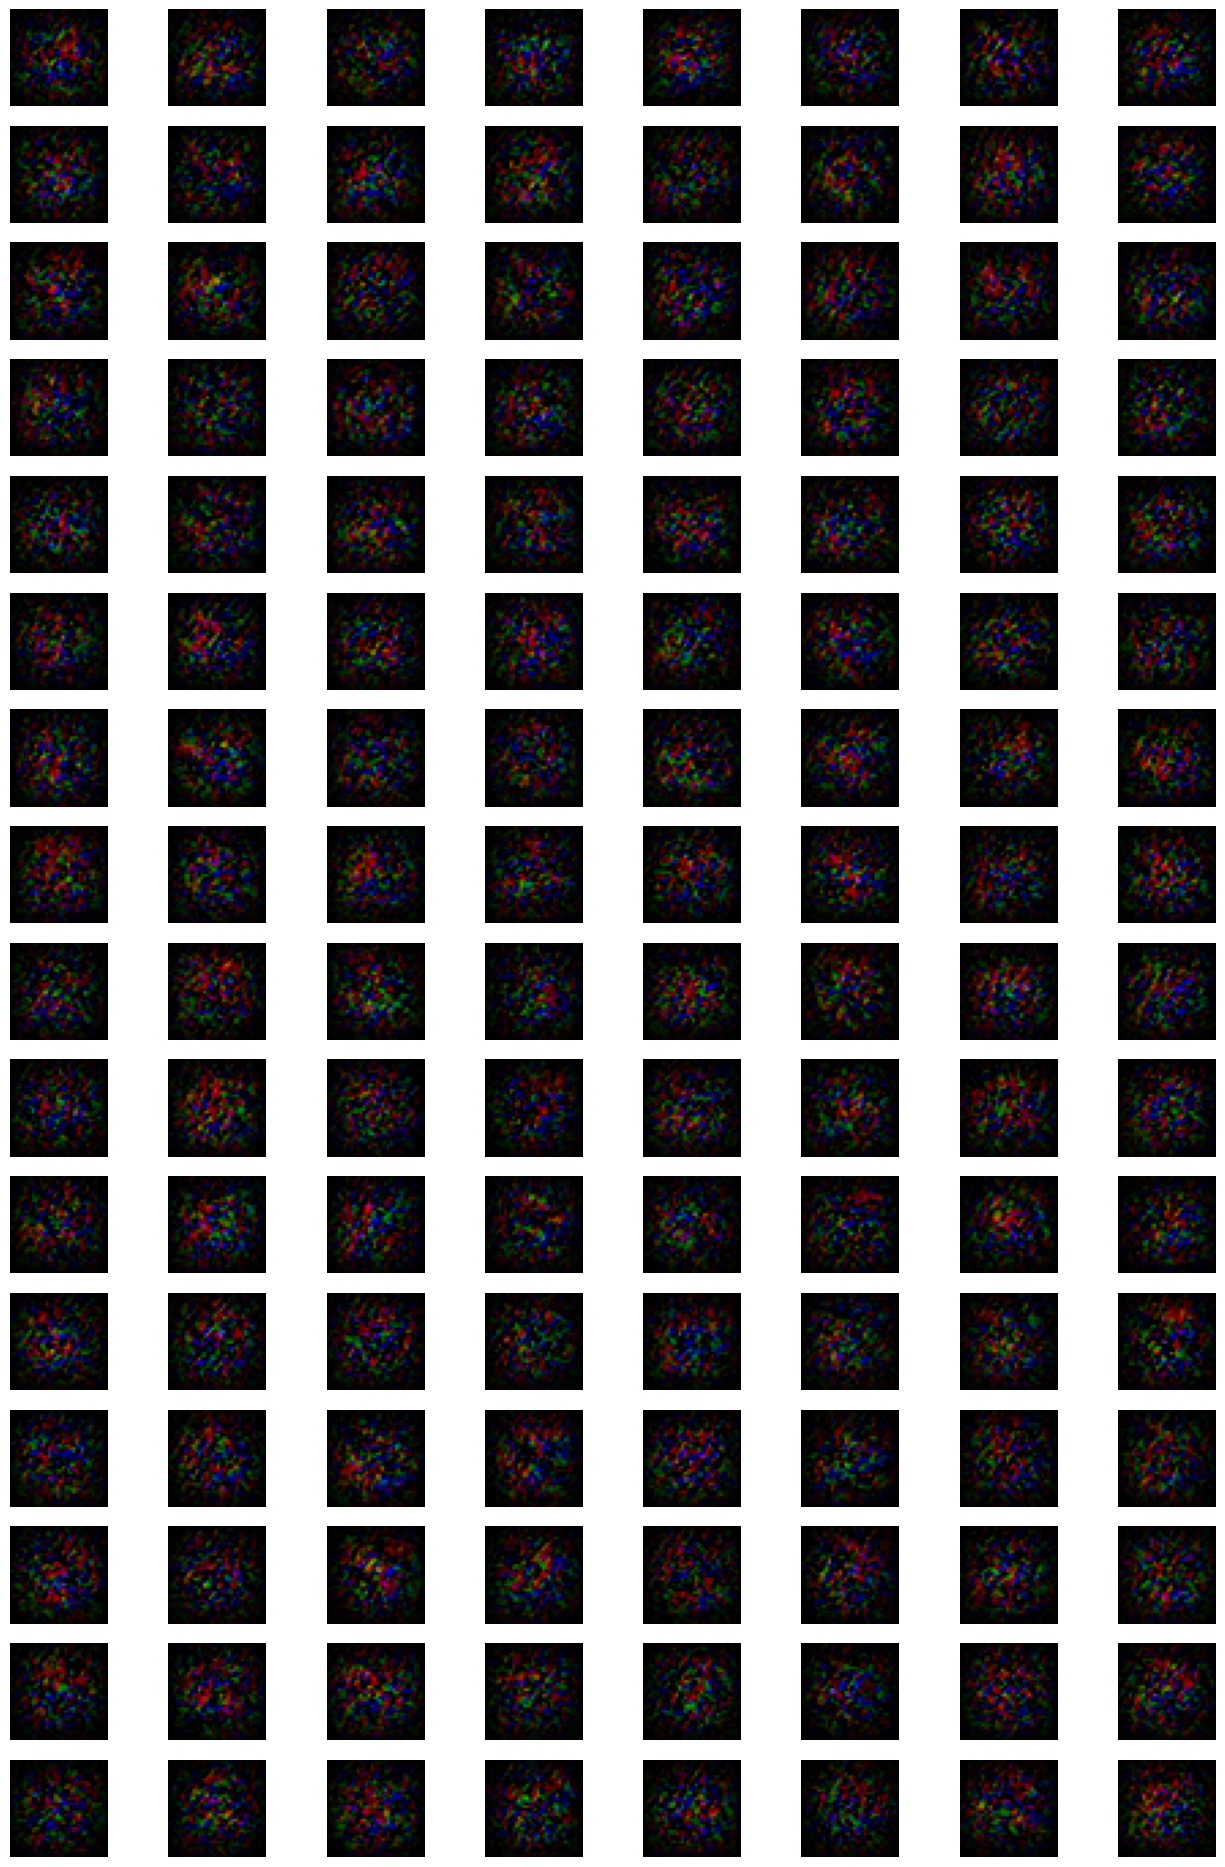

In [ ]:
## Show us some generated faces after our training!
plt.figure(figsize=[16, 24])
sample_images(16, 8);

The biggest problem was unfortunately collab. It was unusable, constatly crashed, allowed me to
use the GPU accelerator for maximum of about 1 hour (then it switched to normal version). I managed to get
some statistics - with the GPU accelerator it took on average 4-5s for 50 epochs, without the accelerator
it was 40-60 s. That made testing any changes to my code almost impossible, since it was taking so
long to see the results.

Another problem was that sometimes the file with the data of weights did not get saved
which meant that after running for two hours all the progress would just get lost. Using collab
in that way was just infuriating as I really couldn't track any progress with my code.

One interesting finding I had - I run the code without the acelerator for several hours and managed to get
to 8000 epochs. That was the result:

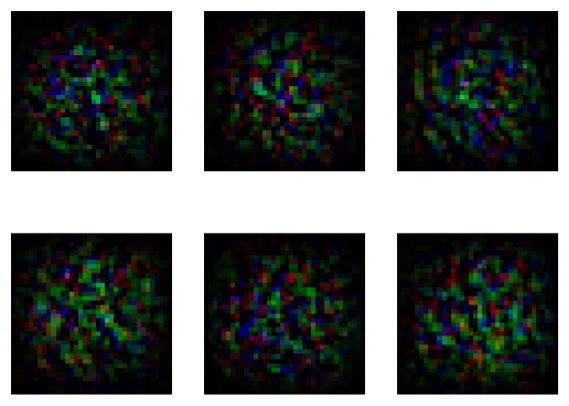

Then collab allowed me to use the GPU accelerator and after running the thing for 16k epochs I got worse results than earlier (it was the same code!)



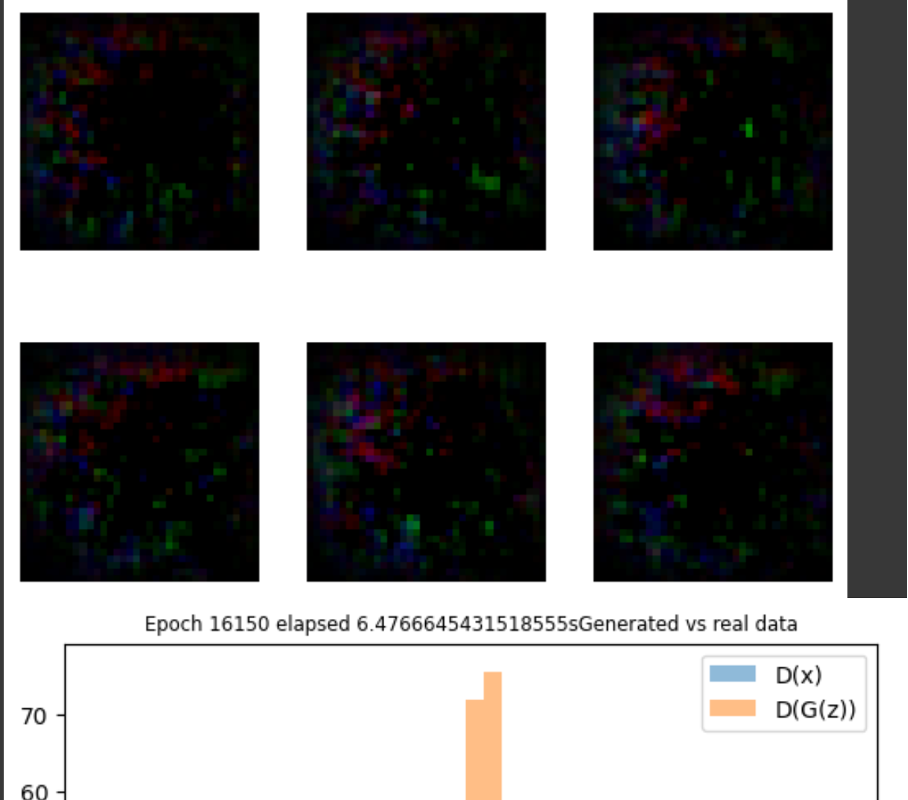

That was quite peculiar since by running longer the model should come at least a little closer to generating more colors on the image - instead it produced much more dark pixels. I guess that one possible explanation for that might be the model getting stuck in some kind of a minimum which would prevent it from learning more.